In [ ]:
from google.colab import drive
import sys
from os.path import join as pjoin

drive.mount('/content/drive/', force_remount=True)
PROJECT_ROOT = "/content/drive/MyDrive/IHDM-talktorial/"
sys.path.append(PROJECT_ROOT)

Mounted at /content/drive/


#### Install required packages

In [ ]:
!pip install blobfile mpi4py numpy opencv_python Pillow torch torchvision wandb omegaconf einops matplotlib

## Tutorial on Generative Modelling with Inverse Heat Dissipation (ICLR 2023)
#### Authors: Severi Rissanen, Markus Heinonen, and Arno Solin

##### by: Soumava Paul (sopa00001@stud.uni-saarland.de)

Paper [here](https://arxiv.org/abs/2206.13397). Official github repository [here](https://github.com/AaltoML/generative-inverse-heat-dissipation). Project page [here](https://aaltoml.github.io/generative-inverse-heat-dissipation/).

In this tutorial notebook, we'll investigate conditional generation properties of the Inverse Heat Dissipation Model (IHDM) for the MNIST and CIFAR10 datasets. Originally, the authors only performed unconditional generation experiments across different datasets, where the deblurring process started from a flat image
with a certain average gray value. Here, we'll observe how a simple class-conditioning embedding can guide the UNet's output to a specific class. This extension enhances the model's intra-class generation variance as the generation landscape becomes more constricted than before (eg., the model is implicitly guided
to generate the digit 1 over any other digit).

But, first, we begin with a few simple illustrations for the 1D and 2D heat equations and how it changes an input signal over time. Then, we'll see how observation noise on top of this deterministic heat equation makes inversion of the heat equation a feasible problem (Algorithm 1 of the paper).
Finally, we'll end with some sample generation results for the MNIST and CIFAR10 datasets.

Optionally, we can also train the model from scratch and observe the training process. Here, we have provided a simple training loop adapted from the main repository with corresponding training configurations in configs/mnist_cond.yaml.
But, we provide the pre-trained weights for both CIFAR10 and MNIST, so you can skip the training process and directly observe the generation results.

You can download weights for the class-conditoned models for both datasets [here](https://nextcloud.mpi-klsb.mpg.de/index.php/s/yAK9Z9kfn8T8fZy).

Place them inside ```runs/{dataset}/conditional/checkpoints-meta/``` where ```dataset={mnist, cifar10}```.

In [ ]:
import os
from os.path import join as pjoin
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import HTML, Image
from matplotlib.animation import FuncAnimation
from einops import repeat, rearrange
from omegaconf import OmegaConf

%load_ext autoreload
%autoreload 2

from scripts import utils

config_mnist = OmegaConf.load(pjoin(PROJECT_ROOT, "configs/mnist_cond.yaml"))
config_cifar = OmegaConf.load(pjoin(PROJECT_ROOT, "configs/cifar10_cond.yaml"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For reproducibility
utils.safe_state(config_mnist.seed, device)

blur_sigma_max = config_mnist.model.blur_sigma_max
blur_sigma_min = config_mnist.model.blur_sigma_min
blur_schedule = np.exp(np.linspace(np.log(blur_sigma_min), np.log(blur_sigma_max), config_mnist.model.K))
blur_schedule_cifar = np.exp(np.linspace(np.log(blur_sigma_min), np.log(blur_sigma_max), config_cifar.model.K))
blur_schedule = np.array([0] + list(blur_schedule))  # Add the k=0 timestep
blur_schedule_cifar = np.array([0] + list(blur_schedule_cifar))  # Add the k=0 timestep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Illustration of 1D heat equation

$$
\frac{\partial T}{\partial t} = \alpha \left( \frac{\partial^2 T}{\partial x^2} \right)
$$

where $T$ is the temperature, $t$ is time, $x$ is the position, and $\alpha$ is the thermal diffusivity. For initial condition $T(x, 0) = f(x)$, and boundary conditions $\frac{\partial T}{\partial x}(0, t) = 0$ and $\frac{\partial T}{\partial x}(L, t) = 0$, the general term of the PDE looks like:

$$
T_n(x, t) = \cos\left(\frac{n\pi x}{L}\right) \exp\left(-\left(\frac{n\pi}{L}\right)^2 \alpha t\right)
$$

where $L$ is the length of the rod, and $n$ stands for the $n^{th}$ harmonic. The complete solution is a linear combination of these terms:

$$
T(x,t) = \sum_{n=0}^{\infty} B_n \cos \left( \frac{n \pi x}{L} \right) \exp \left( -\alpha \left( \frac{n \pi}{L} \right)^2 t \right)
$$

where $B_n$ are the Fourier coefficients. In the matrix exponential form, the solution can be written as:

$$
T(\mathbf{x}, t) = \exp(\mathbf{V} \Lambda \mathbf{V}^T t) T_0
$$

where $\mathbf{V}$ is the matrix of eigenvectors of the laplacian operator, $\Lambda$ is the diagonal matrix of eigenvalues of the laplacian operator, and $T_0$ is the initial temperature distribution $f(x)$. The above equation can be further simplified to:

$$
\begin{align*}
T(\mathbf{x}, t) &= \mathbf{V} \exp(\Lambda t) \mathbf{V}^T T_0 \\
\mathbf{V}^T T(\mathbf{x}, t) &= \mathbf{V}^T \mathbf{V} \exp(\Lambda t) \mathbf{V}^T T_0 \\
\tilde{T}(\mathbf{x}, t) &= \exp(\Lambda t) \tilde{T}_0 \\
T(\mathbf{x}, t) &= \mathbf{V} \tilde{T}(\mathbf{x}, t)
\end{align*}
$$

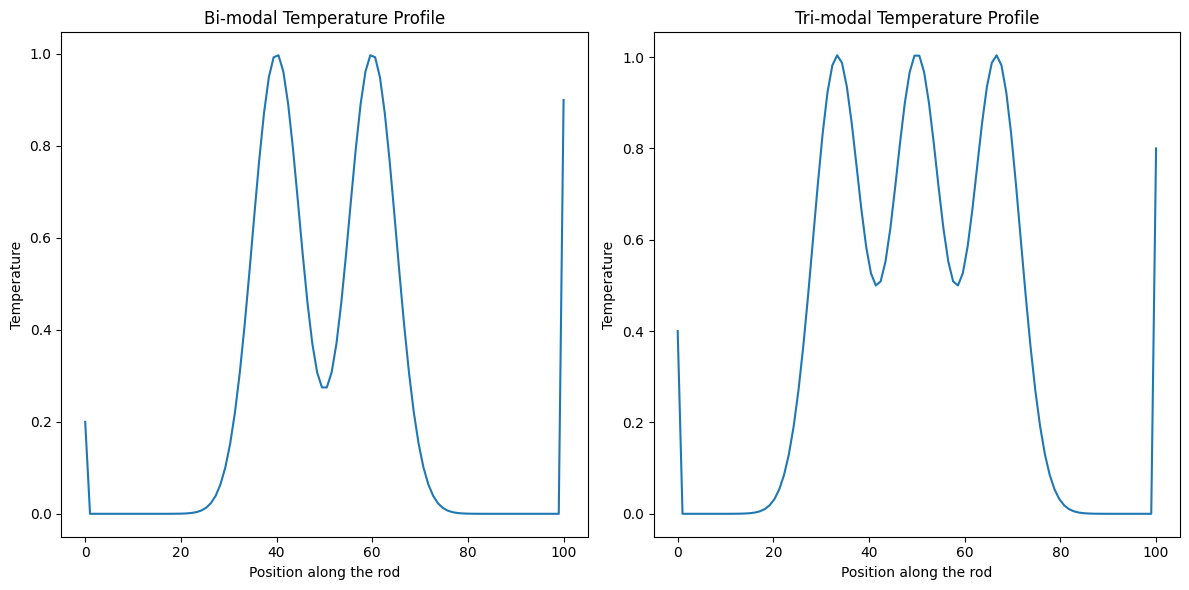

In [ ]:
# Defining intial temperature profile of a rod of length L - a bi-modal or tri-modal distribution

def gaussian(x, mean, std, amplitude=1):
    return amplitude * torch.exp(-((x - mean) ** 2) / (2 * std ** 2))

# Length of the rod
L = 100
x = torch.linspace(0, L, steps=L).to(device)

# Bi-modal temperature distribution
# Two Gaussians with means slightly off the center
mean1 = L / 2 - L / 10
mean2 = L / 2 + L / 10
std = L / 20  # Standard deviation
bi_modal_temp = gaussian(x, mean1, std) + gaussian(x, mean2, std)

# Tri-modal temperature distribution with more spacing
# Two Gaussians symmetrically around the center and one at the center
mean1_tri = L / 2 - L / 6  # First peak moved further left
mean2_tri = L / 2 + L / 6  # Second peak moved further right
mean3 = L / 2  # Center peak
std_tri = L / 20  # Standard deviation
tri_modal_temp_spaced = gaussian(x, mean1_tri, std_tri) + gaussian(x, mean2_tri, std_tri) + gaussian(x, mean3, std_tri)

# We deliberately set the edge values to be non-zero to show how the Neumann boundary condition sets in after t > 0
bi_modal_temp[0] = 0.2
bi_modal_temp[-1] = 0.9

tri_modal_temp_spaced[0] = 0.4
tri_modal_temp_spaced[-1] = 0.8

# Plotting the temperature distributions
plt.figure(figsize=(12, 6))

# Bi-modal temperature profile
plt.subplot(1, 2, 1)
plt.plot(x.cpu().numpy(), bi_modal_temp.cpu().numpy())
plt.title("Bi-modal Temperature Profile")
plt.xlabel("Position along the rod")
plt.ylabel("Temperature")

# Updated Tri-modal temperature profile
plt.subplot(1, 2, 2)
plt.plot(x.cpu().numpy(), tri_modal_temp_spaced.cpu().numpy())
plt.title("Tri-modal Temperature Profile")
plt.xlabel("Position along the rod")
plt.ylabel("Temperature")

plt.tight_layout()
plt.show()

Next, we will define some animation utility functions to visualize the heat equation (1D or 2D) changes an initial data distribution over time. For this, we'll observe the temperature evolution of a 1D rod over time which was heated at the center at time $t=0$.
And when applied to a 2D images, we'll observe the progressive blurring of the image as the 2D heat equation gradually "melts" it. Note that, the forward pass of the heat equation is a deterministic process, and not a stochastic Markov noising process as seen in denoising
diffusion models. As we saw above, the heat equation is solved by taking the input first to the Fourier domain, and then applying a matrix exponential of the eigenvalues of the Laplacian operator, and then transforming it back to the spatial domain using inverse DCT.

The ```DCTBlur1D``` and ```DCTBlur2D``` classes defined in ```models/torch_dct.py``` implement this functionality for 1D and 2D inputs respectively. We can "deterministically" infer the blurred output at a given time $t$ by calling the ```forward``` method of these classes using the
initial input and the time $t$ as input arguments.

In [ ]:
from models.torch_dct import DCTBlur1D, DCTBlur2D
from scripts import datasets, losses

heat_forward_module_1D = DCTBlur1D(blur_schedule, L, device)
heat_forward_module_2D_mnist = DCTBlur2D(blur_schedule, config_mnist.data.image_size, device)
heat_forward_module_2D_cifar = DCTBlur2D(blur_schedule_cifar, config_cifar.data.image_size, device)
fwd_steps = torch.linspace(1, config_mnist.model.K, config_mnist.model.K, dtype=torch.long, device=device)
fwd_steps_cifar = torch.linspace(1, config_cifar.model.K, config_cifar.model.K, dtype=torch.long, device=device)

In [ ]:
def animate_rod_temperature(x, temp_profile):
    fig, ax = plt.subplots()
    # Plot the static background data
    ax.plot(x.cpu().numpy(), temp_profile[0].cpu().numpy(), label='Temperature Profile at t=0')
    # Setting the title and labels
    ax.set_title('Temperature Profile at different time steps')
    ax.set_xlabel('Position along the rod')
    ax.set_ylabel('Temperature')

    # Initialize the line for the animated part of the plot
    line, = ax.plot([], [], lw=2, label='Temperature at t=0')  # Initial empty line
    ax.set_xlim(0, L)  # Adjust x-axis limits based on your data
    ax.set_ylim(0, 1)  # Adjust y-axis limits based on your data
    ax.legend()

    def init():
        """Initialize the background of the animation."""
        line.set_data([], [])
        return line,

    def animate(i):
        """Update the plot for each frame."""
        y = temp_profile[i].cpu().numpy()
        line.set_data(x.cpu().numpy(), y)
        line.set_label(f'Temperature at t={i}')  # Update the line label with the current frame
        ax.legend()  # Update the legend
        return line,

    # Create animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=temp_profile.shape[0], interval=100, blit=True)

    return HTML(anim.to_html5_video())


def animate_image_blurring(blurred_images, cmap=None):
    fig, ax = plt.subplots()
    num_channels = blurred_images.shape[1]

    # Use 'imshow' to display the first image; set the colormap to 'gray' for grayscale
    im = ax.imshow(rearrange(blurred_images[0], 'c h w -> h w c').cpu().numpy(), cmap=cmap, vmin=0, vmax=1)
    ax.axis('off')

    # Adding dynamic text annotation for timestep
    # Position the text at the top-left corner of the axes
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color="yellow", fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

    def init():
        """Initialize the animation with an empty frame."""
        im.set_data(np.zeros((blurred_images.shape[-2], blurred_images.shape[-1], num_channels)))
        time_text.set_text('')  # Initialize the text
        return im, time_text


    def animate(i):
        """Update the image for each frame."""
        im.set_data(rearrange(blurred_images[i], 'c h w -> h w c').cpu().numpy())
        time_text.set_text(f'Image at t={i}')  # Update the text with the current timestep
        return im, time_text

    # Create the animation
    anim = FuncAnimation(fig, animate, init_func=init, frames=blurred_images.shape[0], interval=100, blit=True)

    # Alternatively, to save the animation to a file
    # anim.save('grayscale_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])

    # To display the animation in a Jupyter notebook
    return HTML(anim.to_html5_video())

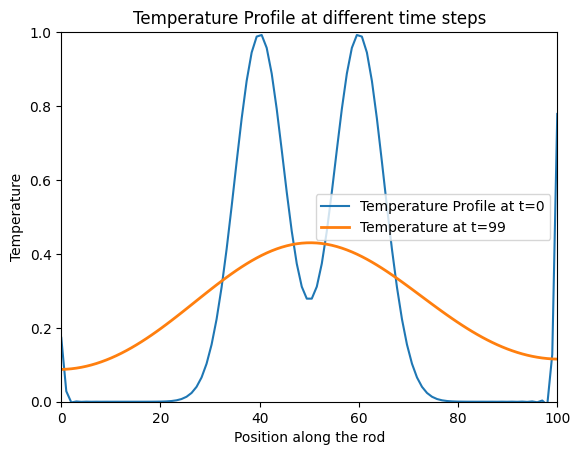

In [ ]:
temp_across_timesteps = heat_forward_module_1D(repeat(bi_modal_temp, 'd -> N d', N=config_mnist.model.K), fwd_steps)
animate_rod_temperature(x, temp_across_timesteps)

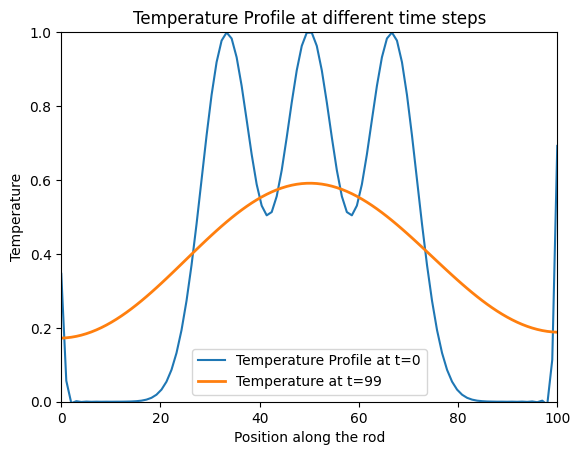

In [ ]:
temp_across_timesteps = heat_forward_module_1D(repeat(tri_modal_temp_spaced, 'd -> N d', N=config_mnist.model.K), fwd_steps)
animate_rod_temperature(x, temp_across_timesteps)

We can notice in the animations above, that the derivatives at the edges of the rod gradually go towards zero because of the homogeneous Neumann boundary conditions, and the temperature distribution becomes more and more uniform (diffused) over time. This is because the heat equation is a diffusion equation, and it diffuses the heat from the center to the edges of the rod. This is also the reason why the heat equation is used in image processing for blurring images as we'll see in the next set of animations.

### 2D Heat Equation on Images

(-0.5, 27.5, 27.5, -0.5)

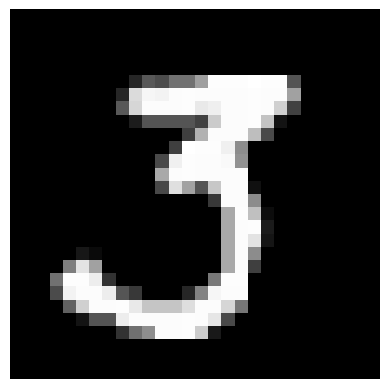

In [ ]:
_, testloader = datasets.get_dataset(config_mnist, uniform_dequantization=config_mnist.data.uniform_dequantization, eval_batch_size=1)
sample_img_mnist = next(iter(testloader))[0].to(device)
sample_img_mnist = repeat(sample_img_mnist, 'b c h w -> (b K) c h w', K=config_mnist.model.K)
plt.imshow(sample_img_mnist[0, 0].cpu().numpy(), cmap='gray')
plt.axis('off')

Files already downloaded and verified
Files already downloaded and verified


(-0.5, 31.5, 31.5, -0.5)

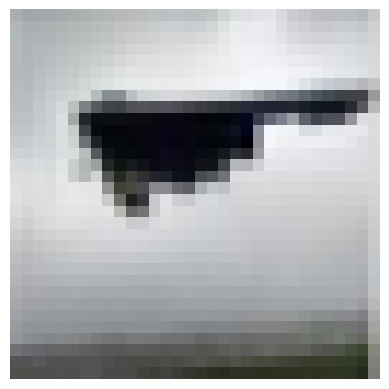

In [ ]:
_, testloader = datasets.get_dataset(config_cifar, uniform_dequantization=config_cifar.data.uniform_dequantization, eval_batch_size=1)
sample_img_cifar = next(iter(testloader))[0].to(device)
sample_img_cifar = repeat(sample_img_cifar, 'b c h w -> (b K) c h w', K=config_cifar.model.K)
plt.imshow(np.transpose(sample_img_cifar[0].cpu().numpy(), (1, 2, 0)))
plt.axis('off')

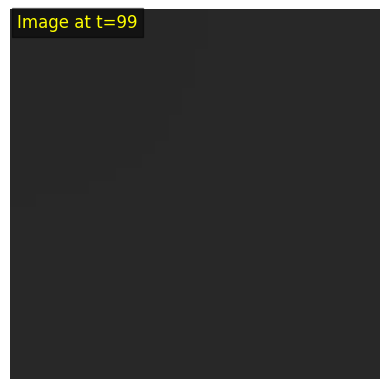

In [ ]:
blurred_image_across_timesteps = heat_forward_module_2D_mnist(sample_img_mnist, fwd_steps)
animate_image_blurring(blurred_image_across_timesteps, cmap='gray')

The final image at t=100 is a uniform gray image, which is the steady state solution of the heat equation. The average gray value of the final image is the same as the initial image.
The evolution above follows the 2D heat equation:


$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial x^2} \right)
$$

whose general solution is given by:

$$
u(x, y, t) = \sum_{n=0}^{\infty} \sum_{m=0}^{\infty} B_{n,m} \cos \left( \frac{n \pi x}{L} \right) \cos \left( \frac{m \pi y}{L} \right) \exp \left( -\alpha \left( \frac{n^2 + m^2}{L^2} \right) t \right)
$$

The equation above is a straightforward extension of the solution to the 1D heat equation stated above. The only difference is that the solution is now a double sum over the Fourier coefficients $B_{n,m}$, and the eigenvalues of the Laplacian operator are now $n^2 + m^2$ instead of $n^2$ in the 1D case. The Fourier domain solution is the same as the 1D case, only the dimension of the matrices are different as the Laplacian operator is now 2D instead of 1D.

Below, we see the same 2D heat equation applied to a CIFAR10 image. Following the settings of the paper, we run the blurring process for K=200 timesteps until we end up with a flat RGB image.

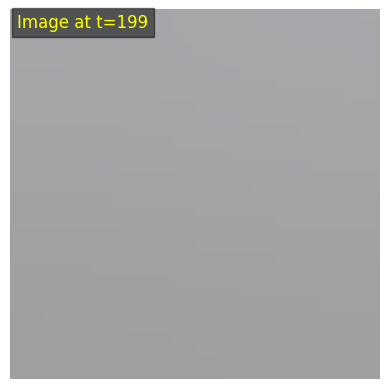

In [ ]:
blurred_image_across_timesteps = heat_forward_module_2D_cifar(sample_img_cifar, fwd_steps_cifar)
animate_image_blurring(blurred_image_across_timesteps, cmap=None)

In [ ]:
workdir = pjoin(PROJECT_ROOT, "runs/mnist/conditional_1") # directory for saving checkpoints and evaluation outputs

## wandb credentials

wandb_credentials = {
    "project": "ihdm-talktorial",
    "entity": "", # your username goes here
    "name": "mnist_class_cond", # name of the experiment, change it as needed
    "dir": workdir # where to save local logs and checkpoints
}

USE_WANDB = False # set to True to log metrics to wandb

### Train a class-conditional model on MNIST

##### Feel free to skip this part and jump directly to the sampling algorithm below if you have downloaded the pre-trained weights.

In [ ]:
from models.ema import ExponentialMovingAverage

In [ ]:
# Create directory for saving intermediate samples
sample_dir = pjoin(workdir, "samples")
Path(sample_dir).mkdir(parents=True, exist_ok=True)

# create wandb project
if USE_WANDB:
    import wandb
    run = wandb.init(**wandb_credentials)
    run.name = run.name + f'-{run.id}'
    assert run is wandb.run

model = utils.create_model(config_mnist, device)
optimizer = utils.get_optimizer(config_mnist, model.parameters())

ema = ExponentialMovingAverage(model.parameters(), decay=config_mnist.model.ema_rate)
state = dict(optimizer=optimizer, model=model, step=0, ema=ema)
model_evaluation_fn = utils.get_model_fn(model, train=False)

# Create checkpoints directory
checkpoint_dir = pjoin(workdir, "checkpoints")
# Intermediate checkpoints to resume training
checkpoint_meta_dir = pjoin(workdir, "checkpoints-meta", "checkpoint.pth")
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)
Path(os.path.dirname(checkpoint_meta_dir)).mkdir(parents=True, exist_ok=True)
# Resume training when intermediate checkpoints are detected
state = utils.restore_checkpoint(checkpoint_meta_dir, state, device)
initial_step = int(state['step'])

# Build data iterators
trainloader, testloader = datasets.get_dataset(config_mnist, uniform_dequantization=config_mnist.data.uniform_dequantization)
train_iter = iter(trainloader)
eval_iter = iter(testloader)

Implementation of the training algorithm

<img src="https://raw.githubusercontent.com/mvp18/IHDM-talktorial/main/media/algo1.png" alt="Training Algorithm" title="Training Algorithm" width="700" height="400"/>

In [ ]:
def get_inverse_heat_loss_fn(config, train, heat_forward_module):

    sigma = config.model.sigma
    label_sampling_fn = losses.get_label_sampling_function(config.model.K)

    def loss_fn(model, x, y):
        model_fn = utils.get_model_fn(model, train=train)  # get train/eval model
        fwd_steps = label_sampling_fn(x.shape[0], x.device)
        blurred_batch = heat_forward_module(x, fwd_steps).float()
        less_blurred_batch = heat_forward_module(x, fwd_steps-1).float()
        noise = torch.randn_like(blurred_batch) * sigma
        perturbed_data = noise + blurred_batch
        diff = model_fn(perturbed_data, fwd_steps, y)
        prediction = perturbed_data + diff
        losses = (less_blurred_batch - prediction)**2
        losses = torch.sum(losses.reshape(losses.shape[0], -1), dim=-1)
        loss = torch.mean(losses)
        return loss, losses, fwd_steps

    return loss_fn

# Get the forward process definition
loss_fn_train = get_inverse_heat_loss_fn(config_mnist, train=True, heat_forward_module=heat_forward_module_2D_mnist)
loss_fn_eval = get_inverse_heat_loss_fn(config_mnist, train=False, heat_forward_module=heat_forward_module_2D_mnist)

In [ ]:
# Build one-step training and evaluation functions
optimize_fn = losses.optimization_manager(config_mnist)

# Get the loss function
train_step_fn = losses.get_step_fn(train=True, config=config_mnist, loss_fn=loss_fn_train, optimize_fn=optimize_fn)
eval_step_fn = losses.get_step_fn(train=False, config=config_mnist, loss_fn=loss_fn_eval, optimize_fn=optimize_fn)

#### Training loop

In [ ]:
num_train_steps = config_mnist.training.n_iters

for step in range(initial_step, num_train_steps + 1):
        # Train step
        try:
            batch = next(train_iter)
        except StopIteration:  # Start new epoch if run out of data
            train_iter = iter(trainloader)
            batch = next(train_iter)

        x = batch[0].to(device).float()
        y = batch[1].to(device) if config_mnist.data.num_classes is not None else None
        loss, losses_batch, fwd_steps_batch = train_step_fn(state, x, y)

        if USE_WANDB: wandb.log({"training_loss": loss.item()}, step)

        # Save a temporary checkpoint to resume training if training is stopped
        if step != 0 and step % config_mnist.training.snapshot_freq_for_preemption == 0:
            ("Saving temporary checkpoint")
            utils.save_checkpoint(checkpoint_meta_dir, state)

        # Report the loss on an evaluation dataset periodically
        if step % config_mnist.training.eval_freq == 0:
            print("Starting evaluation")
            # Use 25 batches for test-set evaluation, arbitrary choice
            N_evals = 25
            for i in range(N_evals):
                try:
                    eval_batch = next(eval_iter)
                except StopIteration:  # Start new epoch
                    eval_iter = iter(testloader)
                    eval_batch = next(eval_iter)

                x_eval = eval_batch[0].to(device).float()
                y_eval = eval_batch[1].to(device) if config_mnist.data.num_classes is not None else None
                eval_loss, losses_batch, fwd_steps_batch = eval_step_fn(state, x_eval, y_eval)
                eval_loss = eval_loss.detach()
                if USE_WANDB: wandb.log({"eval_loss": eval_loss.item()}, step)
            print(f"step: {step}, eval_loss: {eval_loss.item()}")

        # Save a checkpoint periodically
        if step != 0 and step % config_mnist.training.snapshot_freq == 0 or step == num_train_steps:
            print("Saving a checkpoint")
            # Save the checkpoint.
            save_step = step // config_mnist.training.snapshot_freq
            utils.save_checkpoint(pjoin(checkpoint_dir, 'checkpoint_{}.pth'.format(save_step)), state)

        # Generate samples periodically
        # if step != 0 and step % config_mnist.training.sampling_freq == 0 or step == num_train_steps:
        #     print("Sampling...")
        #     ema.store(model.parameters())
        #     ema.copy_to(model.parameters())
        #     sample, intermediate_samples = sampling_fn(model_evaluation_fn)
        #     ema.restore(model.parameters())
        #     this_sample_dir = pjoin(sample_dir, "iter_{}".format(step))
        #     Path(this_sample_dir).mkdir(parents=True, exist_ok=True)
        #     # utils.save_tensor(this_sample_dir, sample, "final.np")
        #     utils.save_png(this_sample_dir, sample, "final.png")
        #     if initial_sample != None: utils.save_png(this_sample_dir, initial_sample, "init.png")
        #     # utils.save_gif(this_sample_dir, intermediate_samples)
        #     utils.save_video(this_sample_dir, intermediate_samples)

if USE_WANDB: run.finish()

##### Implementation of the Sampling Algorithm

<img src="https://raw.githubusercontent.com/mvp18/IHDM-talktorial/main/media/algo2.png" alt="Sampling Algorithm" title="Sampling Algorithm" width="700" height="400"/>

In [ ]:
def get_initial_sample(config, forward_heat_module, device, batch_size=None):
    """Take a draw from the prior p(u_K)"""
    trainloader, _ = datasets.get_dataset(config, uniform_dequantization=config.data.uniform_dequantization, train_batch_size=batch_size)

    initial_sample = next(iter(trainloader))
    initial_images = initial_sample[0].to(device)
    original_class = initial_sample[1].to(device) if config.data.num_classes is not None else None
    initial_sample = forward_heat_module(initial_images, config.model.K * torch.ones(initial_images.shape[0], dtype=torch.long).to(device))
    return initial_sample, original_class


def get_sampling_fn_inverse_heat(config, initial_sample, initial_class, intermediate_sample_indices, delta, device, share_noise=False):
    """ Returns our inverse heat process sampling function.
    Arguments:
    initial_sample: Pytorch Tensor with the initial draw from the prior p(u_K)
    intermediate_sample_indices: list of indices to save (e.g., [0,1,2,3...] or [0,2,4,...])
    delta: Standard deviation of the sampling noise
    share_noise: Whether to use the same noises for all elements in the batch
    """
    K = config.model.K

    def sampler(model):

        if share_noise:
            noises = [torch.randn_like(initial_sample[0], dtype=torch.float)[None] for i in range(K)]

        intermediate_samples_out = []

        with torch.no_grad():
            u = initial_sample.to(device).float()
            if intermediate_sample_indices != None and K in intermediate_sample_indices:
                intermediate_samples_out.append((u, u))
            for i in range(K, 0, -1):
                vec_fwd_steps = torch.ones(initial_sample.shape[0], device=device, dtype=torch.long) * i
                # Predict less blurry mean
                u_mean = model(u, vec_fwd_steps, initial_class) + u
                # Sampling step
                if share_noise:
                    noise = noises[i-1]
                else:
                    noise = torch.randn_like(u)

                u = u_mean + noise*delta
                # Save trajectory
                if intermediate_sample_indices != None and i-1 in intermediate_sample_indices:
                    intermediate_samples_out.append((u, u_mean))

            return u_mean, [u for (u, u_mean) in intermediate_samples_out]

    return sampler

In [ ]:
delta = config_mnist.model.sigma * 1.25
# Building sampling functions
initial_sample, initial_class = get_initial_sample(config_mnist, heat_forward_module_2D_mnist, device)
sampling_fn = get_sampling_fn_inverse_heat(config_mnist, initial_sample, initial_class, intermediate_sample_indices=list(range(config_mnist.model.K+1)), delta=delta, device=device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Sampling using a Trained Checkpoint

In [ ]:
def sample(config, heat_forward_module, batch_size, same_init_u=False, same_init_class=False, share_noise=False, workdir=None, suffix="cifar"):

    intermediate_sample_indices = list(range(config.model.K+1))
    delta = config.model.sigma * 1.25 # The standard deviation of noise to add at each step with predicted reverse blur

    # Directory name for saving results
    sample_dir = pjoin(workdir, "additional_samples")
    this_sample_dir = pjoin(sample_dir, "checkpoint_0")
    this_sample_dir = pjoin(this_sample_dir, "delta_{}".format(delta))

    checkpoint_dir = pjoin(workdir, "checkpoints-meta")
    print(checkpoint_dir)
    model = utils.load_model_from_checkpoint_dir(config, checkpoint_dir, device, suffix=suffix)
    model_fn = utils.get_model_fn(model, train=False)
    print(f"Loaded model from {checkpoint_dir} running on {device}")

    initial_sample, initial_class = get_initial_sample(config, heat_forward_module, device, batch_size=batch_size)
    initial_sample = initial_sample[:batch_size]

    if same_init_u:
        initial_sample = torch.cat(batch_size * [initial_sample[0][None]], 0)
        this_sample_dir += "_same_init"
    if same_init_class:
        initial_class = torch.cat(batch_size * [initial_class[0][None]], 0)
        this_sample_dir += "_same_class"
    if share_noise:
        this_sample_dir += "_share_noise"

    Path(this_sample_dir).mkdir(parents=True, exist_ok=True)
    sampling_fn = get_sampling_fn_inverse_heat(config, initial_sample, initial_class, intermediate_sample_indices, delta, device, share_noise=share_noise)
    sample, intermediate_samples = sampling_fn(model_fn)

    utils.save_png(this_sample_dir, sample, "final.png")
    utils.save_png(this_sample_dir, initial_sample, "init.png")
    utils.save_video(this_sample_dir, intermediate_samples)

    if config.data.dataset == "CIFAR10":
        cifar_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        initial_class = [cifar_classes[i] for i in initial_class.cpu().numpy()]
    print(f"Sample classes: {initial_class}")
    print(f"Output sample saved at {this_sample_dir}")
    return Image(pjoin(this_sample_dir, "final.png"))

In [ ]:
workdir_mnist = pjoin(PROJECT_ROOT, "runs/mnist/conditional")
workdir_cifar = pjoin(PROJECT_ROOT, "runs/cifar10/conditional")
sample_batch_size = 12

##### No sharing across samples

/content/drive/MyDrive/IHDM-talktorial/runs/mnist/conditional/checkpoints-meta
Loaded model from /content/drive/MyDrive/IHDM-talktorial/runs/mnist/conditional/checkpoints-meta running on cuda:0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Sample classes: tensor([3, 0, 1, 5, 2, 4, 3, 3, 4, 5, 0, 1], device='cuda:0')
Output sample saved at /content/drive/MyDrive/IHDM-talktorial/runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125


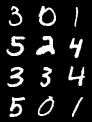

In [ ]:
same_init_u = False
same_init_class = False
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_mnist, suffix="_mnist")

/content/drive/MyDrive/IHDM-talktorial/runs/cifar10/conditional/checkpoints-meta
Loaded model from /content/drive/MyDrive/IHDM-talktorial/runs/cifar10/conditional/checkpoints-meta running on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Sample classes: ['airplane', 'bird', 'airplane', 'deer', 'horse', 'horse', 'cat', 'cat', 'cat', 'ship', 'horse', 'deer']
Output sample saved at /content/drive/MyDrive/IHDM-talktorial/runs/cifar10/conditional/additional_samples/checkpoint_0/delta_0.0125


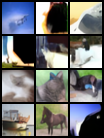

In [ ]:
same_init_u = False
same_init_class = False
share_noise = False

sample(config_cifar, heat_forward_module_2D_cifar, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_cifar, suffix="_cifar")

Observation:

MNIST results are accurate and follow the class signal accurately. CIFAR10 results look to be accurate for most classes, but the "deer" class generations don't look that plausible. Most of the deer samples have large black regions that don't resemble the class at all. The horse samples are still satisfactory.

##### Sharing the same noise across batch samples in Algorithm 2

runs/mnist/conditional/checkpoints-meta
Loaded model from runs/mnist/conditional/checkpoints-meta running on cuda:0
Sample classes: tensor([6, 4, 6, 0, 9, 5, 2, 4, 4, 2, 0, 4], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_share_noise


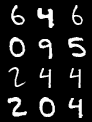

In [ ]:
same_init_u = False
same_init_class = False
share_noise = True

sample(config_mnist, heat_forward_module_2D_mnist, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_mnist, suffix="_mnist")

runs/cifar10/conditional/checkpoints-meta
Loaded model from runs/cifar10/conditional/checkpoints-meta running on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Sample classes: ['automobile', 'ship', 'ship', 'airplane', 'deer', 'airplane', 'truck', 'dog', 'truck', 'automobile', 'bird', 'ship']
Output sample saved at runs/cifar10/conditional/additional_samples/checkpoint_0/delta_0.0125_share_noise


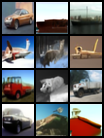

In [ ]:
same_init_u = False
same_init_class = False
share_noise = True

sample(config_cifar, heat_forward_module_2D_cifar, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_cifar, suffix="_cifar")

Observation:

Sharing noise between consecutve timesteps seems to help the model in generating sharper, but not necessarily more accurate samples. The CIFAR10 model improves quite a lot on the bird and deer classes where we can observe at least some resemblance to the class. The MNIST model seems to benefit only marginally from this change, for example, the digit 0 looks a bit sharper than before.

##### Same prior initialization

runs/mnist/conditional/checkpoints-meta
Loaded model from runs/mnist/conditional/checkpoints-meta running on cuda:0
Sample classes: tensor([5, 3, 5, 6, 5, 6, 9, 4, 0, 3, 1, 4], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init


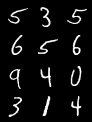

In [ ]:
same_init_u = True
same_init_class = False
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_mnist, suffix="_mnist")

runs/cifar10/conditional/checkpoints-meta


Loaded model from runs/cifar10/conditional/checkpoints-meta running on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Sample classes: ['cat', 'frog', 'truck', 'horse', 'airplane', 'frog', 'deer', 'deer', 'bird', 'frog', 'horse', 'horse']
Output sample saved at runs/cifar10/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init


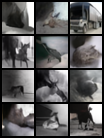

In [ ]:
same_init_u = True
same_init_class = False
share_noise = False

sample(config_cifar, heat_forward_module_2D_cifar, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_cifar, suffix="_cifar")

Observation:

It's easier for the MNIST model to follow the class signal even under the same prior initialization as most digits would most likely "melt down" to similar average gray values. The CIFAR10, however, struggles from every image starting from the average gray value of a cat sample. Only the truck and frog samples look plausible, rest struggle to resemble the class signal due to the initial gray value requirement.

##### Same class conditioning signal for all samples

runs/mnist/conditional/checkpoints-meta
Loaded model from runs/mnist/conditional/checkpoints-meta running on cuda:0
Sample classes: tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_class


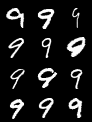

In [ ]:
same_init_u = False
same_init_class = True
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_mnist, suffix="_mnist")

runs/cifar10/conditional/checkpoints-meta


Loaded model from runs/cifar10/conditional/checkpoints-meta running on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Sample classes: ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']
Output sample saved at runs/cifar10/conditional/additional_samples/checkpoint_0/delta_0.0125_same_class


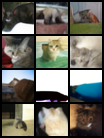

In [ ]:
same_init_u = False
same_init_class = True
share_noise = False

sample(config_cifar, heat_forward_module_2D_cifar, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_cifar, suffix="_cifar")

Observation:

This setting is again easier for the MNIST model to follow the class signal due to reasons mentioned above. But it still does quite well at creating diverse looking "9"'s. However, 2 of the samples are "off" as they seem to resemble "4" and "8" more respectively. For CIFAR10, the model does mostly well at generating cats except 2-3 samples, where the average gray value is quite different from what you'd expect from a cat image.

##### Same prior and same class signal

runs/mnist/conditional/checkpoints-meta
Loaded model from runs/mnist/conditional/checkpoints-meta running on cuda:0
Sample classes: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init_same_class


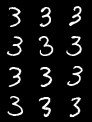

In [ ]:
same_init_u = True
same_init_class = True
share_noise = False

sample(config_mnist, heat_forward_module_2D_mnist, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_mnist, suffix="_mnist")

runs/cifar10/conditional/checkpoints-meta


Loaded model from runs/cifar10/conditional/checkpoints-meta running on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Sample classes: ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']
Output sample saved at runs/cifar10/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init_same_class


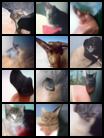

In [ ]:
same_init_u = True
same_init_class = True
share_noise = False

sample(config_cifar, heat_forward_module_2D_cifar, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_cifar, suffix="_cifar")

Observation:

This is the most limited setting for the model, and it's quite hard for even the MNIST model to generate diverse samples. But because of 2 simultaneous constraints, the CIFAR10 model seems to do the best here at creating a sample well representative of the class signal except maybe 1 or 2 erroneous samples.

##### Same prior initialization and sharing noise

runs/mnist/conditional/checkpoints-meta
Loaded model from runs/mnist/conditional/checkpoints-meta running on cuda:0
Sample classes: tensor([8, 4, 4, 5, 5, 9, 5, 3, 3, 1, 2, 9], device='cuda:0')
Output sample saved at runs/mnist/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init_share_noise


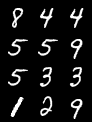

In [ ]:
same_init_u = True
same_init_class = False
share_noise = True

sample(config_mnist, heat_forward_module_2D_mnist, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_mnist, suffix="_mnist")

runs/cifar10/conditional/checkpoints-meta
Loaded model from runs/cifar10/conditional/checkpoints-meta running on cuda:0
Files already downloaded and verified
Files already downloaded and verified
Sample classes: ['frog', 'dog', 'automobile', 'airplane', 'bird', 'horse', 'airplane', 'truck', 'horse', 'dog', 'cat', 'horse']
Output sample saved at runs/cifar10/conditional/additional_samples/checkpoint_0/delta_0.0125_same_init_share_noise


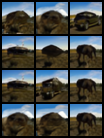

In [ ]:
same_init_u = True
same_init_class = False
share_noise = True

sample(config_cifar, heat_forward_module_2D_cifar, sample_batch_size, same_init_u, same_init_class, share_noise, workdir_cifar, suffix="_cifar")

Observation:

The MNIST model is able to generate sharp representative class samples because of noise sharing even with the constraint of prior initialization. However, this additional constraint cripples the CIFAR10 model as it struggles to generate accurate samples for classes whose average gray values tend to lie close to the prior of the first sample (here, frog). Hence, only automobile, horse, and truck samples look plausible. Airplane, cat, and dog samples are quite off the mark.

### Conclusion:

In this notebook, we have investigated class-conditonal generation of the Inverse Heat Dissipation Model (IHDM) for the MNIST and CIFAR10 datasets. The main takeaway seems to be an unconditional model (as observed in the paper) for RGB images would be skewed towards generating a only a specific set of classes without any class conditioning signal, but just based on the prior distribution. However, with a class input, the model will try to generate an instance of the target class with an average gray value that it may not have encountered during training. However, the generation may not look always plausible as certain classes are only correlated with a certain range of average gray levels in the training data. This is a limitation of the model, and it would be interesting to see how the model can be extended to generate more plausible samples with a class conditioning signal. Sharing noise across batch samples seems to be beneficial for generating sharper samples.

The CIFAR10 dataset is more challenging than MNIST under constraints like same prior initialization and same class signal as the average gray values of the classes are more diverse. The model struggles to generate plausible samples for classes whose average gray values are quite different from the prior initialization. The model seems to do well for classes whose average gray values are close to the prior initialization. As future work, it'll be interesting to see if IHDM can be extended to a stable-diffusion like latent space model and interpret blurring/deblurring as a diffusion process in the latent space.